# CS412 - Machine Learning - Fall 2025
## Homework 3


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google Drive. You must upload both CelebA30k.zip and CelebA30k.csv to your Drive without renaming them.
CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Task

The task in this homework is to perform binary **smiling** classification on a subset of the CelebA dataset using transfer learning.

A pretrained VGG-16 model will be adapted to the task, and its performance will be evaluated under several settings. You will replace the classification head with a binary output layer and train the model for a fixed number of 10 epochs per configuration.

You must:
- Freeze appropriate parts of the pretrained model according to the strategy you choose and only modify the classification head.
- Evaluate your models using the following hyperparameters:
  - 10 epochs
  - Learning rate: 0.0001
  - Fine-tuning strategies:
    1. Freeze all convolutional layers and train only the classifier head.
    2. Freeze all weights except the last convolutional block and the classifier head, and fine-tune those parameters.
- Apply Random Horizontal Flip and a light Color Jitter during training, then discuss how these augmentations affect the smiling classification performance.

**Dataset:** CelebA  
**Model:** VGG-16  
**Library:** PyTorch  

---

## Software

You will use the PyTorch framework for this homework. PyTorch offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.


## 1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

In [1]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Import necessary libraries

import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

import numpy as np

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [5]:
data = pd.read_csv('/content/drive/My Drive/CS412 HW3 Data/CelebA30k.csv') # enter the file path on your drive for the csv file
data.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
smile_data = data[['filename', 'Smiling']].copy()
smile_data.head()

,filename,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,-1
3,000004.jpg,-1
4,000005.jpg,-1


In [10]:
import os

# Unzip ONCE into /content/data
zip_path = "/content/drive/My Drive/CS412 HW3 Data/CelebA30k.zip"
target_dir = "/content/data/CelebA30k"

if not os.path.exists(target_dir):
    print("Extracting dataset")
    !unzip -q "{zip_path}" -d "/content/data"
    print("Extraction complete")
else:
    print("Dataset already extracted, skipping unzip.")

# Set image directory
img_dir = target_dir
print("Using dataset at:", img_dir)

Extracting dataset
Extraction complete
Using dataset at: /content/data/CelebA30k


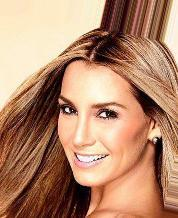

In [11]:
first_image_path = os.path.join("/content/data/CelebA30k/",data.loc[0, "filename"])

img = Image.open(first_image_path)
img

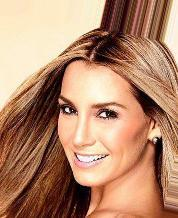

In [12]:
img

# Starting here, you’ll need to fill in the code cells on your own.

## 3) Visualizing/Understanding the dataset

- Display five random images together with their smiling labels.
- Display statistics about the dataset, such as the distribution of smiling vs. not-smiling samples and any other attributes that you find informative.


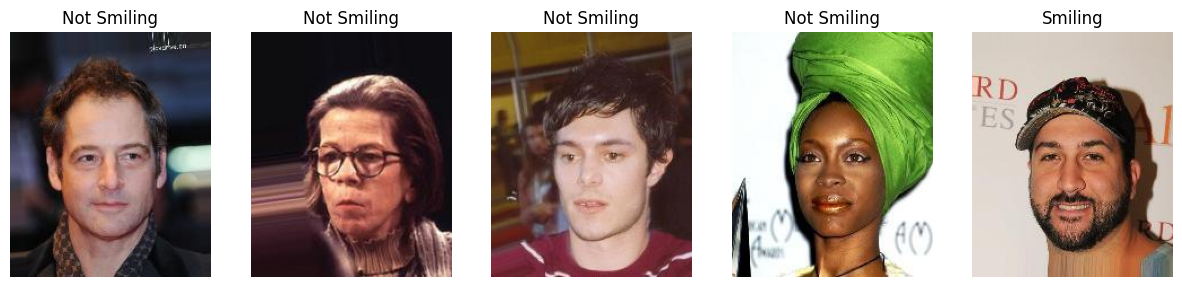

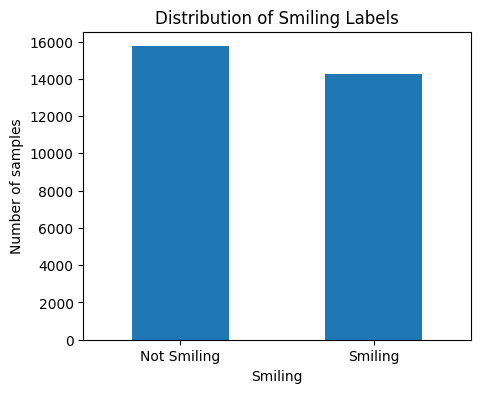

Smiling label distribution:
Smiling
-1    15741
 1    14259
Name: count, dtype: int64


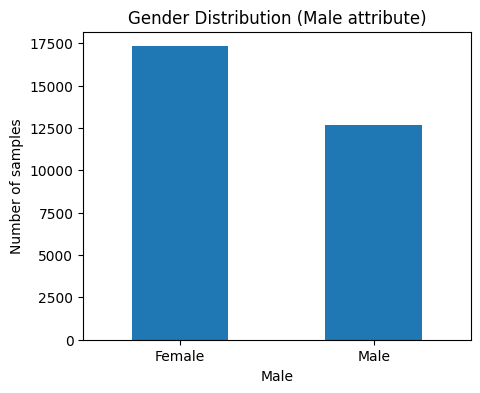

Gender distribution:
Male
-1    17320
 1    12680
Name: count, dtype: int64


In [13]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# Displaying 5 random images with smiling labels

sample_df = data.sample(5).reset_index(drop=True)

plt.figure(figsize=(15, 5))

for i in range(5):
    img_path = os.path.join(img_dir, sample_df.loc[i, "filename"])
    img = Image.open(img_path)

    smiling_label = sample_df.loc[i, "Smiling"]
    label_text = "Smiling" if smiling_label == 1 else "Not Smiling"

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(label_text)
    plt.axis("off")

plt.show()

#Smiling distribution

smile_counts = data["Smiling"].value_counts()

plt.figure(figsize=(5, 4))
smile_counts.plot(kind="bar")
plt.xticks([0, 1], ["Not Smiling", "Smiling"], rotation=0)
plt.title("Distribution of Smiling Labels")
plt.ylabel("Number of samples")
plt.show()

print("Smiling label distribution:")
print(smile_counts)

#informative attribute: Male

male_counts = data["Male"].value_counts()

plt.figure(figsize=(5, 4))
male_counts.plot(kind="bar")
plt.xticks([0, 1], ["Female", "Male"], rotation=0)
plt.title("Gender Distribution (Male attribute)")
plt.ylabel("Number of samples")
plt.show()

print("Gender distribution:")
print(male_counts)

## 4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [14]:
from sklearn.model_selection import train_test_split

# set random seed
RANDOM_SEED = 42

# split data into train and remaining
train_df, temp_df = train_test_split(
    data,
    test_size=0.2,
    random_state=RANDOM_SEED,
    shuffle=True
)

# split remaining data into validation and test 50-50
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=RANDOM_SEED,
    shuffle=True
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

## 5) Preparing the Data

In this section, you will implement the dataset loading and preprocessing pipeline using PyTorch.

You are provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Smiling`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Your task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5, 0.5, 0.5]` for simplicity)
   - Include `RandomHorizontalFlip` and a light `ColorJitter` (e.g., low brightness/contrast adjustments) for the training set to satisfy the augmentation requirement
2. Write a custom `Dataset` class that reads images and smiling labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size.
4. Keep notes on how the applied augmentations might influence the smiling classification results so you can reflect on them in your discussion


In [21]:
# transforms for training data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1,contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

# transforms for validation data
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

# custom Dataset class
class CelebaDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.img_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")

        # label: map -1,1 to 0,1 like sigmoid
        label_raw = row["Smiling"]
        label = 1.0 if label_raw == 1 else 0.0

        if self.transform is not None:
            image = self.transform(image)

        return image, label

# create datasets
train_dataset = CelebaDataset(train_df, img_dir, transform=train_transform)
val_dataset   = CelebaDataset(val_df,   img_dir, transform=val_transform)

# create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

test_dataset = CelebaDataset(test_df, img_dir, transform=val_transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for smiling classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with weights=models.VGG16_Weights.IMAGENET1K_V1 torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [16]:
# load pretrained VGG-16 model
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# get input size of the last classifier layer
in_features = vgg16.classifier[6].in_features

# replace last layer with a new linear layer
vgg16.classifier[6] = nn.Linear(in_features, 1)  # output dim = 1

# move model to device (cpu or cuda)
model = vgg16.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 100MB/s] 


## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:

- Experiment with the two required fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block together with the classifier head and fine-tune those parameters while keeping the earlier layers frozen.
- Use `nn.BCEWithLogitsLoss()` as the loss function and choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- For each fine-tuning strategy, train models with `learning rate = 0.0001`). Each configuration must run for exactly 10 epochs with the mandated data augmentation pipeline.
- Implement a training loop that includes validation after each epoch and monitor both training and validation performance across epochs.
- Keep track of the training duration and include it in your reports.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

**Reporting requirements:**

- Final training and validation accuracy for both configurations.
- Plots for each setup, showing training and validation loss across epochs.
- A table showing training-validation loss, accuracy, and training duration of the models.
- A discussion regarding:
  1. Which fine-tuning strategy performed best and why,
  2. How the Random Horizontal Flip + Color Jitter augmentation influenced the results.


**Note:** Normally, this setup is not optimal for hyperparameter tuning and you would want to experiment with different learning rates, batch sizes, freezing strategies etc. The tuned parameters were kept limited to have reasonable training times and GPU consumptions in this study. If you are curious, you are more than welcome to experiment with other parameters. Especially, `learning rate = 0.001` gives interesting results when used in a fine-tuned model (i.e. when the last convolutional block is not frozen).   


In [17]:
import time
import torch.optim as optim

EPOCHS = 10
LEARNING_RATE = 0.0001
criterion = nn.BCEWithLogitsLoss()

# build new VGG-16 model with our binary head
def build_model():
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    in_features = vgg.classifier[6].in_features
    vgg.classifier[6] = nn.Linear(in_features, 1)  # output = 1 logit
    return vgg.to(device)

# train function for one strategy
def train_model(strategy_name, unfreeze_last_block=False):
    model = build_model()

    # freeze all conv layers first
    for param in model.features.parameters():
        param.requires_grad = False

    # for strategy 2: unfreeze last conv block
    if unfreeze_last_block:
        for param in model.features[24:].parameters():
            param.requires_grad = True

    # optimizer only for trainable parameters
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LEARNING_RATE
    )

    train_losses = []
    val_losses = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(EPOCHS):
        # training
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)

        # validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                probs = torch.sigmoid(outputs)
                preds = (probs >= 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # print to keep track of training and validation
        print(
            f"{strategy_name} | Epoch {epoch+1}/{EPOCHS} "
            f"Train loss: {epoch_train_loss:.4f} "
            f"Val loss: {epoch_val_loss:.4f} "
            f"Val acc: {epoch_val_acc:.4f}"
        )

    duration = time.time() - start_time
    print(f"{strategy_name} | Training time: {duration:.1f} seconds")

    return model, train_losses, val_losses, val_accuracies, duration


# Strategy 1: freeze all conv layers, train only classifier head
model_s1, s1_train_loss, s1_val_loss, s1_val_acc, s1_time = train_model(
    "Strategy 1 (freeze conv)", unfreeze_last_block=False
)

# Strategy 2: unfreeze last conv block + classifier head
model_s2, s2_train_loss, s2_val_loss, s2_val_acc, s2_time = train_model(
    "Strategy 2 (last block + head)", unfreeze_last_block=True
)

Strategy 1 (freeze conv) | Epoch 1/10 Train loss: 0.4206 Val loss: 0.3485 Val acc: 0.8453
Strategy 1 (freeze conv) | Epoch 2/10 Train loss: 0.3135 Val loss: 0.3309 Val acc: 0.8503
Strategy 1 (freeze conv) | Epoch 3/10 Train loss: 0.2722 Val loss: 0.3415 Val acc: 0.8450
Strategy 1 (freeze conv) | Epoch 4/10 Train loss: 0.2379 Val loss: 0.3288 Val acc: 0.8573
Strategy 1 (freeze conv) | Epoch 5/10 Train loss: 0.2106 Val loss: 0.3572 Val acc: 0.8463
Strategy 1 (freeze conv) | Epoch 6/10 Train loss: 0.1814 Val loss: 0.3844 Val acc: 0.8533
Strategy 1 (freeze conv) | Epoch 7/10 Train loss: 0.1507 Val loss: 0.4123 Val acc: 0.8533
Strategy 1 (freeze conv) | Epoch 8/10 Train loss: 0.1333 Val loss: 0.4427 Val acc: 0.8527
Strategy 1 (freeze conv) | Epoch 9/10 Train loss: 0.1135 Val loss: 0.5236 Val acc: 0.8457
Strategy 1 (freeze conv) | Epoch 10/10 Train loss: 0.0944 Val loss: 0.5356 Val acc: 0.8507
Strategy 1 (freeze conv) | Training time: 2561.6 seconds
Strategy 2 (last block + head) | Epoch 1/1

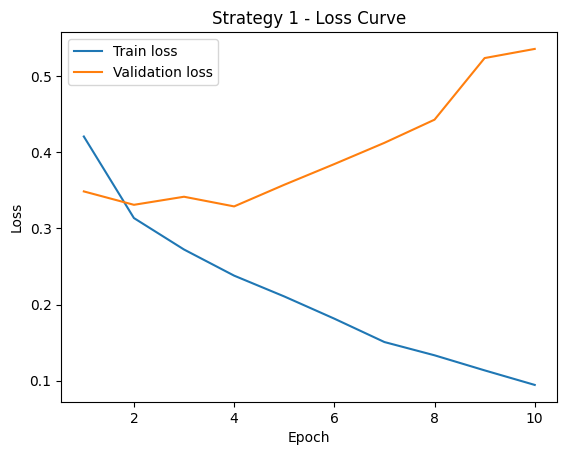

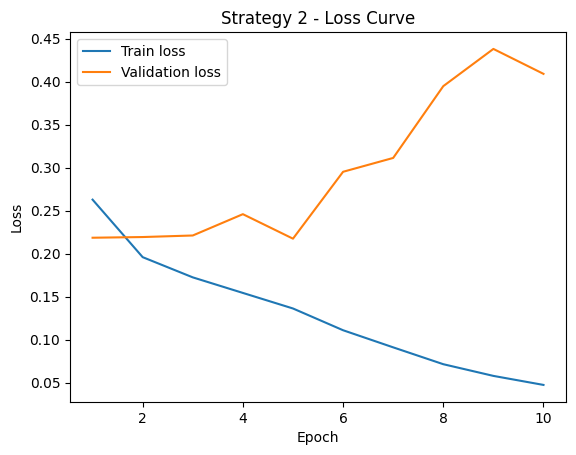

In [ ]:
import matplotlib.pyplot as plt

# Strategy 1: losses from the logs
s1_train_loss = [0.4206, 0.3135, 0.2722, 0.2379, 0.2106,
                 0.1814, 0.1507, 0.1333, 0.1135, 0.0944]

s1_val_loss   = [0.3485, 0.3309, 0.3415, 0.3288, 0.3572,
                 0.3844, 0.4123, 0.4427, 0.5236, 0.5356]

# Strategy 2: losses from the logs
s2_train_loss = [0.2628, 0.1959, 0.1724, 0.1543, 0.1362,
                 0.1109, 0.0910, 0.0714, 0.0578, 0.0473]

s2_val_loss   = [0.2185, 0.2193, 0.2211, 0.2459, 0.2174,
                 0.2952, 0.3113, 0.3948, 0.4381, 0.4091]

epochs = range(1, 11)  


# Strategy 1 loss curve
plt.figure()
plt.plot(epochs, s1_train_loss, label="Train loss")
plt.plot(epochs, s1_val_loss,   label="Validation loss")
plt.title("Strategy 1 - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Strategy 2 loss curve
plt.figure()
plt.plot(epochs, s2_train_loss, label="Train loss")
plt.plot(epochs, s2_val_loss,   label="Validation loss")
plt.title("Strategy 2 - Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 8) Test your classifier on Test set

- Determine the setup with the best performance based on validation set performance.
- Use your model to predict the labels of the test set and report the final accuracy.
- Display the confusion matrix.
- Display 5 correct, 5 incorrect classifications.
- Include the findings in your report, and ensure that the distinction between training and test results is clearly distinguishable.


Best strategy on validation: Strategy 2 (last block + head)
Test accuracy: 0.9123


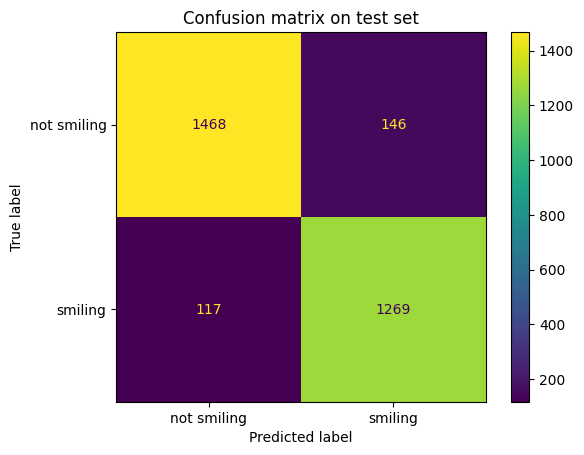

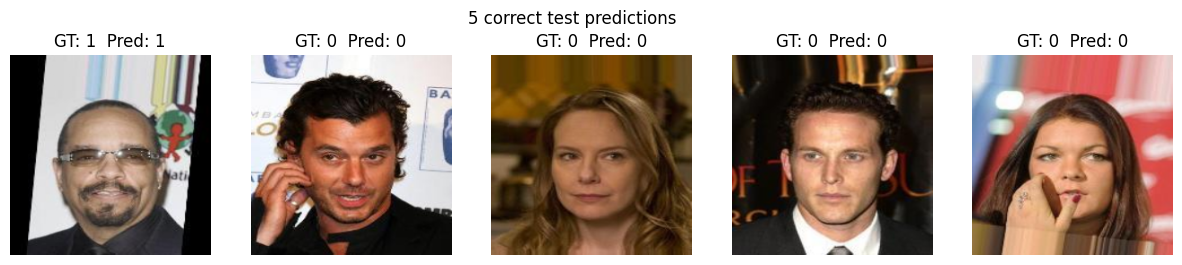

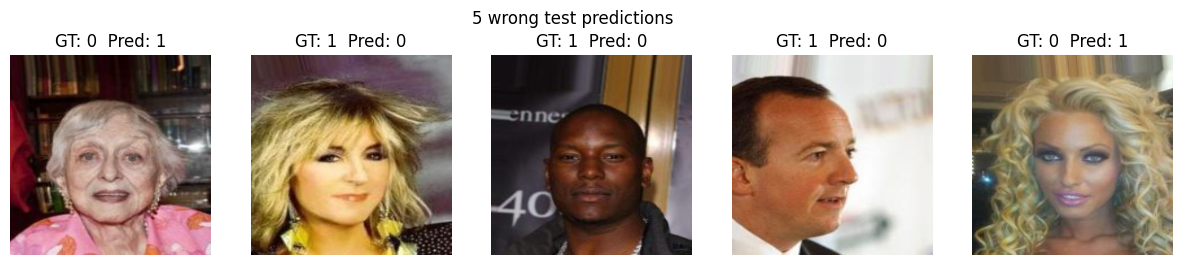

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# chooses the best strategy by validation accuracy
avg_s1 = float(sum(s1_val_acc) / len(s1_val_acc))
avg_s2 = float(sum(s2_val_acc) / len(s2_val_acc))

if avg_s2 >= avg_s1:
    best_model = model_s2
    best_name = "Strategy 2 (last block + head)"
else:
    best_model = model_s1
    best_name = "Strategy 1 (freeze conv)"

print(f"Best strategy on validation: {best_name}")
best_model.eval()

# run on test set
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = best_model(images).squeeze(1)   # [batch]
        probs = torch.sigmoid(logits)            # [0,1]
        preds = (probs >= 0.5).long()            # 0 or 1

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())

all_labels = torch.cat(all_labels).numpy()
all_preds = torch.cat(all_preds).numpy()

test_acc = (all_labels == all_preds).mean()
print(f"Test accuracy: {test_acc:.4f}")

# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["not smiling", "smiling"])

fig, ax = plt.subplots()
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion matrix on test set")
plt.show()

# pick 5 correct and 5 wrong examples

correct_examples = []
wrong_examples = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = best_model(images).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()

        for img, y, p in zip(images, labels, preds):
            y_int = int(y.item())
            p_int = int(p.item())

            if y_int == p_int and len(correct_examples) < 5:
                correct_examples.append((img.cpu(), y_int, p_int))
            elif y_int != p_int and len(wrong_examples) < 5:
                wrong_examples.append((img.cpu(), y_int, p_int))

            if len(correct_examples) >= 5 and len(wrong_examples) >= 5:
                break
        if len(correct_examples) >= 5 and len(wrong_examples) >= 5:
            break

# helper: undo normalization
def unnormalize(img_tensor):
    img = img_tensor * 0.5 + 0.5
    img = img.clamp(0.0, 1.0)
    return img

# show 5 correct predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, (img, y, p) in zip(axes, correct_examples):
    img_show = unnormalize(img).permute(1, 2, 0).numpy()
    ax.imshow(img_show)
    ax.set_title(f"GT: {y}  Pred: {p}")
    ax.axis("off")
fig.suptitle("5 correct test predictions")
plt.show()

# show 5 wrong predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, (img, y, p) in zip(axes, wrong_examples):
    img_show = unnormalize(img).permute(1, 2, 0).numpy()
    ax.imshow(img_show)
    ax.set_title(f"GT: {y}  Pred: {p}")
    ax.axis("off")
fig.suptitle("5 wrong test predictions")
plt.show()